In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import viz
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join as oj
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2

import data
import validate
outcome_def = 'iai_intervention' # output
MODELS_DIR = '../models/simple_3_splits'
os.makedirs(MODELS_DIR, exist_ok=True)


# load the data
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

# split the idxs
train_idxs = df.cv_fold.isin(data.pecarn_train_idxs)
test_idxs1 = df.cv_fold.isin(data.pecarn_test_idxs)
test_idxs2 = df.cv_fold.isin(data.psrc_train_idxs + data.psrc_test_idxs)

# split the data
X, y = df, df[outcome_def]
half = train_idxs.sum() // 2
split_to_plot = '_test2'

# 3-split
X_train, y_train = X[train_idxs], y[train_idxs]
X_cv, y_cv = X_train, y_train
X_test1, y_test1 = X[test_idxs1], y[test_idxs1]
X_test2, y_test2 = X[test_idxs2], y[test_idxs2]

data_sizes = {
    'train': (y_train.sum(), X_train.shape[0]),
    'cv': (y_cv.sum(), X_cv.shape[0]),
    'test1': (y_test1.sum(), X_test1.shape[0]),
    'test2': (y_test2.sum(), X_test2.shape[0]),
}     
def predict_and_save(model, model_name='decision_tree', split_to_plot='_cv'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_test1, X_test2, X_cv], [y_train, y_test1, y_test2, y_cv], 
                            ['_train', '_test1', '_test2', '_cv']):
        sens, spec, threshes = validate.sensitivity_specificity_curve(y,
                                                                      model.predict_proba(x)[:, 1],
                                                                      plot=suffix == split_to_plot)
        plt.title(split_to_plot[1:])
        results['sens' + suffix] = sens
        results['spec' + suffix] = spec
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))        
    return sens, spec, threshes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [6]:
X_train.head()

,iai_intervention,cv_fold,dset,InitHeartRate,GCSScore_Full_yes,CostalTender_yes,Age<2_yes,AbdTenderDegree_None,MOI_unknown,Race_American Indian or Alaska Native,...,Age,DecrBreathSound_yes,AbdDistention_yes,VomitWretch_unknown,AbdDistention_unknown,AbdTrauma_no,AbdDistention_or_AbdomenPain_no,ThoracicTrauma_no,AbdDistention_or_AbdomenPain_yes,Age<2_no
1,0,4,pecarn,102.0,1,1,0,1,0,0,...,3.0,0,0,0,0,1,1,0,0,1
3,0,1,pecarn,74.0,1,0,0,1,0,0,...,11.0,0,0,0,0,1,1,1,0,1
4,0,2,pecarn,103.0,1,0,0,1,0,0,...,16.0,0,0,0,0,1,1,1,0,1
5,0,4,pecarn,124.0,1,0,1,1,0,0,...,1.0,0,0,0,0,0,1,0,0,0
7,0,1,pecarn,122.0,1,1,0,1,0,0,...,9.0,0,0,0,0,1,1,0,0,1


**test individual rule**

In [7]:
def pred_rule(X):
    yhat = (X['AbdTenderDegree_None']==0) | (X['GCSScore_Full_yes'] == 0)
    return yhat.astype(int)

y_train_pred = pred_rule(X_train)
print(f'train sens: {100*validate.sensitivity_score(y_train, y_train_pred):.2f}, {100*validate.specificity_score(y_train, y_train_pred):0.2f}')
y_test1_pred = pred_rule(X_test1)
print(f'test1 sens: {100*validate.sensitivity_score(y_test1, y_test1_pred):.2f}, {100*validate.specificity_score(y_test1, y_test1_pred):0.2f}')
y_test2_pred = pred_rule(X_test2)
print(f'test2 sens: {100*validate.sensitivity_score(y_test2, y_test2_pred):.2f}, {100*validate.specificity_score(y_test2, y_test2_pred):0.2f}')

train sens: 88.72, 59.35
test1 sens: 90.00, 57.83
test2 sens: 95.16, 60.16


In [8]:
def pecarn_top_rules(X):
    yhat = X['AbdTrauma_or_SeatBeltSign_yes'] | X['GCSScore'].isin(range(14)) | \
           X['AbdTenderDegree_Mild'] | X['AbdTenderDegree_Moderate'] | \
           X['AbdTenderDegree_Severe']
    return yhat.astype(int)

y_train_pec3 = pecarn_top_rules(X_train)
print(f'train sens: {100*validate.sensitivity_score(y_train, y_train_pec3):.2f}, {100*validate.specificity_score(y_train, y_train_pec3):0.2f}')
y_test1_pec3 = pecarn_top_rules(X_test1)
print(f'test1 sens: {100*validate.sensitivity_score(y_test1, y_test1_pec3):.2f}, {100*validate.specificity_score(y_test1, y_test1_pec3):0.2f}')
y_test2_pec3 = pecarn_top_rules(X_test2)
print(f'test2 sens: {100*validate.sensitivity_score(y_test2, y_test2_pec3):.2f}, {100*validate.specificity_score(y_test2, y_test2_pec3):0.2f}')

train sens: 91.73, 57.65
test1 sens: 91.43, 55.73
test2 sens: 96.77, 57.10


# test overlap of different rules

**rules make different predictions**

In [46]:
np.corrcoef(y_train_pred, y_train_pec3)

array([[1.        , 0.79301379],
       [0.79301379, 1.        ]])

In [47]:
np.corrcoef(y_test1_pred, y_test1_pec3)

array([[1.        , 0.78537365],
       [0.78537365, 1.        ]])

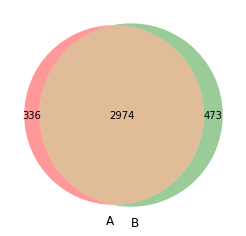

In [48]:
n_train = y_train.size
venn2([set(np.arange(n_train)[y_train_pred==1]),
       set(np.arange(n_train)[y_train_pec3==1])])
plt.show()

**difference in predictions makes little difference for IAI-I**

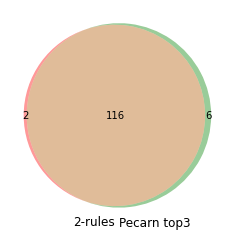

In [51]:
n_train = y_train.size
venn2([set(np.arange(n_train)[(y_train_pred==1) & (y_train==1)]),
       set(np.arange(n_train)[(y_train_pec3==1) & (y_train==1)])],
      set_labels=['2-rules', 'Pecarn top3'])
plt.show()